# 2.2 Simple Taylor Decomposition

## Introduction

In Calculus, a Taylor Series is a representation of a function as an infinite sum of terms that are calculated from the values of the function's derivatives at a single point. Given $f(x)$, a real or complex-valued function that is infinitely differentiable at a real or complex number $a$, it can be expanded with Taylor expansion as

\begin{align}
f(x) & = f(a) + \frac{f'(a)}{1!}(x - a) + \frac{f''(a)}{2!}(x - a)^2 + \frac{f'''(a)}{3!}(x - a)^3 + \cdots \\
     & = \sum^{\infty}_{n = 0} \frac{f^{(n)}(a)}{n!}(x - a)^n
\end{align}

where $n!$ denotes the factorial of $n$ and $f^{n}(a)$ denotes the $n$th derivative of $f$ evaluated at the point $a$. Expansion of $f(x)$ at $a$ only up until the $k$th derivative is called the $k$th-order Taylor expansion at the root point $a$. $k$th-order Taylor expansion only approximates the function at the point $a$ but becomes more accurate as $k$ becomes larger (approaches infinity).

$$f(x) \approx \sum^{k}_{n = 0} \frac{f^{(n)}(a)}{n!}(x - a)^n$$

Note that each term of the Taylor series points out a feature of $f(x)$. For instance, the first term of the series is the value of $f(x)$, the second term is the slope of $f(x)$ and the third term is the curvature of $f(x)$ (all evaluated at the point $a$). That is, the taylor series expansion has decomposed $f(x)$ into meaningful terms. Likewise, the Taylor decomposition is a method that attempts to explain the model's decision by decomposing the function value $f(x)$ as a sum of terms that are meaningful.

The Taylor decomposition is obtained by first identifying a root point $\tilde{x}$ for which $f(\tilde{x}) = 0$. Then the first-order Taylor expansion of $f(x)$ at $\tilde{x}$ is given as

$$f(x) = \sum^{d}_{i = 1} R_i(x) + O(xx^\top)$$

where the relevance scores

$$R_i(x) = \left. \frac{\partial f}{\partial x_i} \right|_{x = \tilde{x}} \cdot (x_i - \tilde{x}_i)$$

are the first-order terms and $O(xx^\top)$ contains all higher-order terms. Because these higher-order terms are typically non-zero, the relevance scores only provides a partial explanation of $f(x)$ (remember how $k$th-order Taylor expansion with finite $k$ only *approximates* $f(x)$. More specifically, a first-order Taylor expansion is a local linear approximation of $f(x)$ as it models a tangent hyperplance at $f(a)$).

However, for special functions, piecewise linear and satisfying the property $f(tx) = tf(x)$ for $t \geq 0$ is not subject to this limitation. These special functions include homogeneous linear models or deep ReLU networks without biases (networks with bias are not homogeneous; that is, $f(tx) \neq tf(x)$). For these functions, we can always find a root point $\tilde{x} \approx 0$ for which $f(\tilde{x}) \approx 0$. Moreover, because they are linear, derivaties of order $2$ and above becomes $0$. In other words, $O(xx^\top) = 0$. Therefore the function can be rewritten as

$$f(x) = \sum^{d}_{i = 1} R_i(x)$$

where the relevance scores are reduced to

$$R_i(x) = \frac{\partial f}{\partial x_i} \cdot x_i$$

Relevance here can be understood as the product of sensitivity $\partial f / \partial x_i$ and saliency $x_i$. That is, an input feature is relevant if it both influences the model's decision and if it is present in the input data. This simple Taylor decomposition will serve as a basis for the more sophisticated deep Taylor decomposition later on in the tutorial.

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_1 import MNIST_DNN

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/2_2_STD/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In this step, a regular DNN classifier is initialized and necessary nodes for model training is added onto the graph. In this particular tutorial, I used a fully connected neural network with ReLU activations and without bias in order to satisfy the $f(tx) = tf(x)$ property mentioned in the introduction.

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_DNN('DNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    logits = DNN(X)

    tf.add_to_collection('STD', X)
    tf.add_to_collection('STD', logits)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 1.175753098 accuracy = 0.593018181
Epoch: 0002 cost = 0.469845834 accuracy = 0.869781818
Epoch: 0003 cost = 0.374617994 accuracy = 0.901327274
Epoch: 0004 cost = 0.338044021 accuracy = 0.913436366
Epoch: 0005 cost = 0.312741951 accuracy = 0.920672730
Epoch: 0006 cost = 0.295141783 accuracy = 0.923963638
Epoch: 0007 cost = 0.281215714 accuracy = 0.927781820
Epoch: 0008 cost = 0.269032245 accuracy = 0.932127276
Epoch: 0009 cost = 0.268163302 accuracy = 0.932309092
Epoch: 0010 cost = 0.263316866 accuracy = 0.935563638
Epoch: 0011 cost = 0.251961106 accuracy = 0.937654548
Epoch: 0012 cost = 0.248318576 accuracy = 0.937636364
Epoch: 0013 cost = 0.237807911 accuracy = 0.940000002
Epoch: 0014 cost = 0.231915841 accuracy = 0.941836365
Epoch: 0015 cost = 0.229651945 accuracy = 0.942181820
Accuracy: 0.9691


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore CNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function (recall prototype subgraph nodes were added onto the 'sensitivity analysis' collection at step 2). We now can calculate the relevance scores by multiplying the gradient calculated by `tf.gradients()` function with `X`.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

nodes = tf.get_collection('STD')
X = nodes[0]
logits = nodes[1]

gradients = tf.gradients(logits, X)
score = tf.multiply(gradients, X)

INFO:tensorflow:Restoring parameters from ./tf_logs/2_2_STD/model


### 5. Calculating Relevance Scores $R_i(x)$

In [5]:
images = mnist.train.images
labels = mnist.train.labels

sample_imgs = []
for i in range(10):
    sample_imgs.append(images[np.argmax(labels, axis=1) == i][3])

scores = sess.run(score, feed_dict={X: sample_imgs})

sess.close()

### 6. Displaying Images

The gradients are visualized as heat maps over the original digit images. You can see which features/data points influenced the DNN most its decision making. Also note that unlike simple sensitivity analysis, the heat map points out features strictly within the digit due to the saliency constraint.

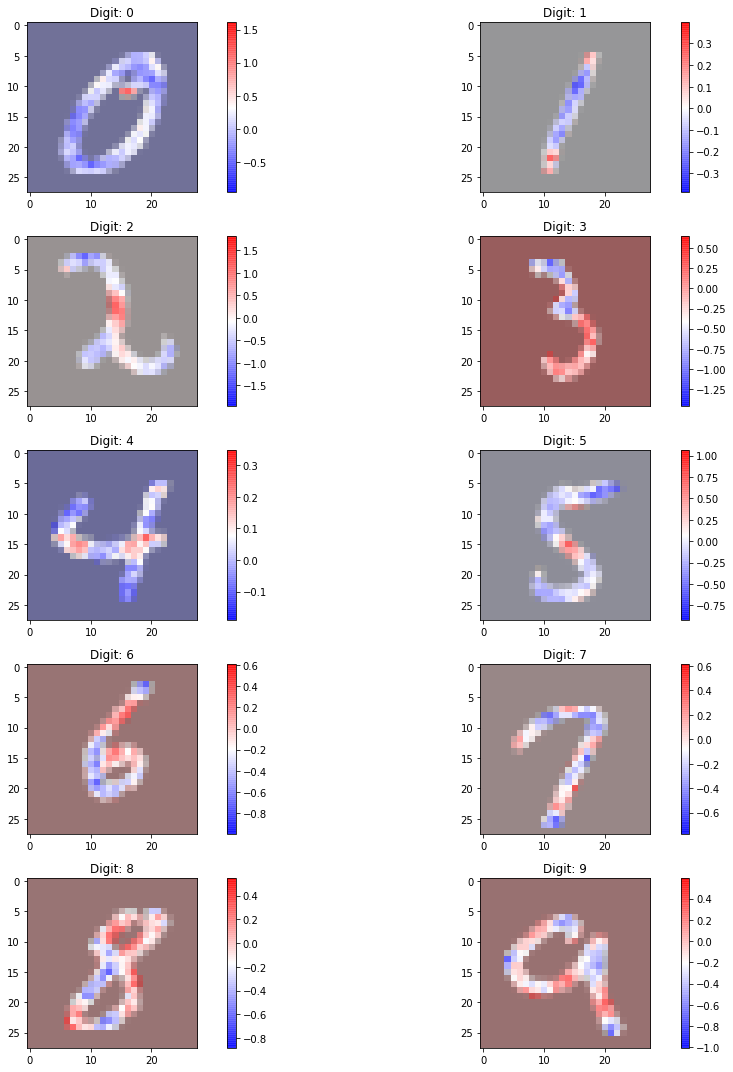

In [6]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(sample_imgs[2 * i], [28, 28]), cmap='gray')
    plt.imshow(np.reshape(scores[0][2 * i], [28, 28]), cmap='bwr', alpha=0.6)
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(sample_imgs[2 * i + 1], [28, 28]), cmap='gray')
    plt.imshow(np.reshape(scores[0][2 * i + 1], [28, 28]), cmap='bwr', alpha=0.6)
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()